In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = self.linear(x)
        h = F.relu(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, use_sigmoid=False):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.use_sigmoid = use_sigmoid

    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        if self.use_sigmoid:
            h = F.sigmoid(h)
        return h

In [4]:
def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    z = mu + eps * sigma
    return z


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder1 = Encoder(input_dim, hidden_dim, latent_dim)
        self.encoder2 = Encoder(latent_dim, hidden_dim, latent_dim)
        self.decoder1 = Decoder(latent_dim, hidden_dim, input_dim, use_sigmoid=True)
        self.decoder2 = Decoder(latent_dim, hidden_dim, latent_dim)

    def get_loss(self, x):
        mu1, sigma1 = self.encoder1(x)
        z1 = reparameterize(mu1, sigma1)
        mu2, sigma2 = self.encoder2(z1)
        z2 = reparameterize(mu2, sigma2)

        z_hat = self.decoder2(z2)
        x_hat = self.decoder1(z1)

        # loss
        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma2 ** 2) - mu2 ** 2 - sigma2 ** 2)
        L3 = - torch.sum(1 + torch.log(sigma1 ** 2) - (mu1 - z_hat) ** 2 - sigma1 ** 2)
        return (L1 + L2 + L3) / batch_size

49.64890407918294
43.24532367757161
41.469331439208986
40.76734126586914
40.37438988342285
40.15274904378255
39.94395666097005
39.79817167154948
39.635260752360026
39.54673320922851
39.42826686808268
39.403002614339194
39.336979382324216
39.264605843098956
39.23433873901367
39.19297360229492
39.14831193440755
39.13408903808594
39.10709464111328
39.065295532226564
39.03404801432292
39.02648302408854
38.975690822347005
38.95352838439941
38.90152508951823
38.93401453450521
38.8728962483724
38.88135961303711
38.88587499593099
38.8374788675944


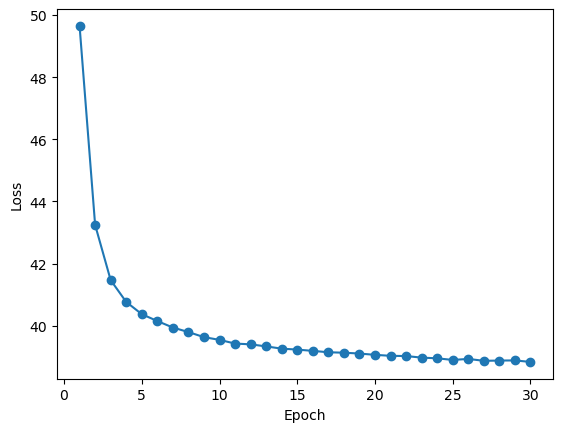

In [5]:
# hyperparameters
input_dim = 784  # mnist image 28x28
hidden_dim = 100
latent_dim = 20
epochs = 30
learning_rate = 1e-3
batch_size = 32


# dataset
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(torch.flatten)
            ])
dataset = datasets.MNIST(
                root='./data',
                train=True,
                download=True,
                transform=transform
            )
dataloader = torch.utils.data.DataLoader(
                dataset,
                batch_size=batch_size,
                shuffle=True
            )

model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []


for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for x, label in dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    print(loss_avg)
    losses.append(loss_avg)


# plot losses
epochs = list(range(1, epochs + 1))
plt.plot(epochs, losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

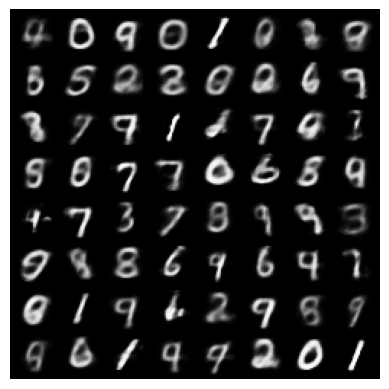

In [6]:
# visualize generated images
with torch.no_grad():
    sample_size = 64
    z2 = torch.randn(sample_size, latent_dim)
    z1_hat = model.decoder2(z2)
    z1 = reparameterize(z1_hat, torch.ones_like(z1_hat))
    x = model.decoder1(z1)
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()